In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import re
import matplotlib.pyplot as plt
import optuna
import pandas as pd
import numpy as np
from prettytable import PrettyTable
from glob import glob

from utils import draw_trajectories, get_metric, plot_metric

# Utils

In [54]:
def plot_gain_dist_by_episode(name, title=None, train=False):
  folder = 'train' if train else 'eval'
  n_envs = len(glob(f'../runs/{name}/{folder}-*'))
  max_nb_episodes = max([len(glob(f'../runs/{name}/{folder}-*{i}/*')) for i in range(n_envs)])

  n_rows = n_envs // 4 + 1
  n_cols = 4
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4), dpi=200)

  def extract_label(filename):
    res = re.search(r'(\d)/(\d)/progress.csv', filename)
    return f'Env {res.group(1)}, Episode {res.group(2)}'
  
  def metric(f, df):
    return np.arange(len(df)), df['obs/cum_obs/vmc/0'].to_numpy()*.1

  for env_id in range(n_envs):
    axs_x = env_id // 4
    axs_y = env_id % 4
    ax = axs[axs_x, axs_y]
    ax.set_title(f'Env {env_id}')
    plot_metric(
      [f'{name}/{folder}-*{env_id}/{i}' for i in range(max_nb_episodes)],
      metric=metric,
      y_label=f'Cum. Dist',
      ax=ax,
      hide_legend=True)
  for i in range(max_nb_episodes):
    axs[1, 3].plot([], [], label=f'Episode {i}')

  plt.subplots_adjust(wspace=0.3, hspace=0.3)
  fig.suptitle(title or name)
  fig.legend(loc='upper center',
              bbox_to_anchor=(0.5, -.05),
              ncol=4)

# Checks

## Is the evaluation scenario exactly the same for all agents? **YES**

<Axes: xlabel='Timesteps', ylabel='Wind cos'>

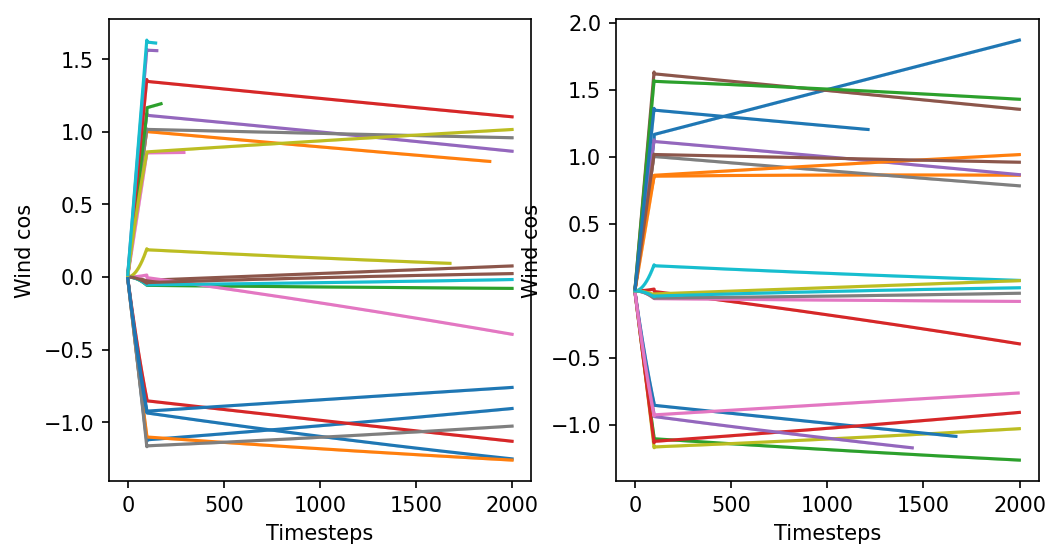

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(2*4, 4), dpi=150)
plot_metric(
    glob('../runs/08-28-max-wind-v1-scenario-1/eval-*/0/*.csv'),
    metric='obs/wind/0',
    y_label='Wind cos',
    ax=axs[0], hide_legend=True)
plot_metric(
    glob('../runs/08-28-max-wind-v2-scenario-1/eval-*/0/*.csv'),
    'obs/wind/0',
    y_label='Wind cos',
    ax=axs[1], hide_legend=True)

<Axes: xlabel='Timesteps', ylabel='Wind sin'>

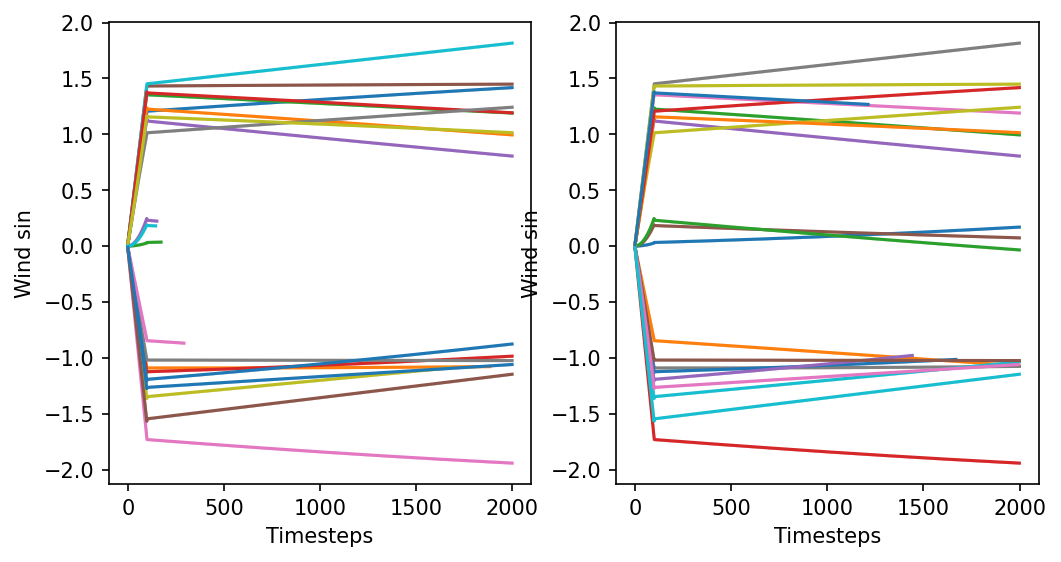

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(2*4, 4), dpi=150)
plot_metric(
    glob('../runs/08-28-max-wind-v1-scenario-1/eval-*/0/*.csv'),
    metric='obs/wind/1',
    y_label='Wind sin',
    ax=axs[0], hide_legend=True)
plot_metric(
    glob('../runs/08-28-max-wind-v2-scenario-1/eval-*/0/*.csv'),
    'obs/wind/1',
    y_label='Wind sin',
    ax=axs[1], hide_legend=True)

<Axes: xlabel='Timesteps', ylabel='Theta Wind'>

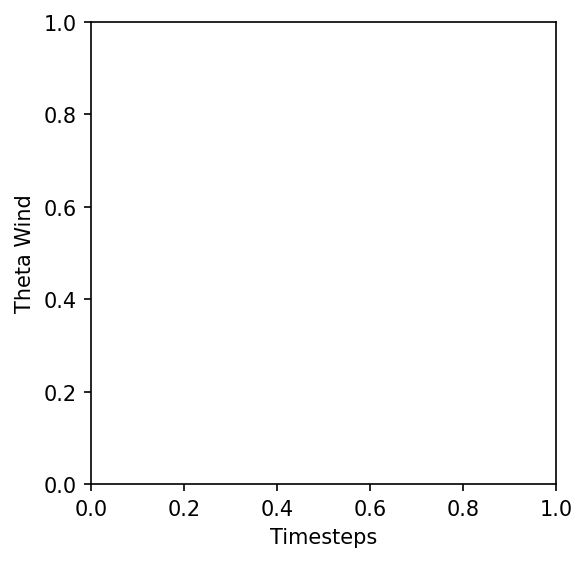

In [7]:
import numpy as np
plot_metric(
    glob('../runs/08-29-test-8/eval-*/0/*.csv'),
    metric=lambda _, df: (np.arange(len(df)), np.arctan2(df['obs/wind/1'].values, df['obs/wind/0'].values)),
    y_label='Theta Wind',
    hide_legend=True)

## Best hyperparameters selection

based on theses results, we will use the following hyperparameters for the final evaluation:

```bash
python3 scripts/sb3_train_and_eval.py --policy-kwargs="{'net_arch': dict(pi=[256, 256], vf=[256, 256]), 'activation_fn': nn.ReLU, 'ortho_init': False}" --batch-size=8 --n-steps=1024 --gamma=0.999 --gae-lambda=.9 --max-grad-norm=0.6 --learning-rate=3e-05 --vf-coef=0.2 --n-epochs=10"
```

In [13]:
def get_k_best_hyperparams(k, majority_cols=['clip_range', 'batch_size', 'n_steps', 'n_epochs', 'gamma', 'gae_lambda', 'max_grad_norm'], study_name='sb3-tuning-coktailjet-7-trials'):
    study = optuna.load_study(study_name=study_name, storage='sqlite:///../optuna.db')
    df = study.trials_dataframe(multi_index=True)
    df.sort_values(('value'), inplace=True, ascending=False)
    df = df['params'].head(k)
    print(f'Best hyperparameters (k={k}):')
    for col, col_type in zip(df.columns, df.dtypes):
        if col_type == object or col_type == bool or col_type == str or col in majority_cols:
            print(f'\t{col}:\t{df[col].mode().item()}')
        else:
            print(f'\t{col}:\t{df[col].mean():.2e}±{df[col].std():.2e} (median={df[col].median():.2e})')

In [11]:
get_k_best_hyperparams(5)
print()
get_k_best_hyperparams(10)
print()
get_k_best_hyperparams(20)
print()
get_k_best_hyperparams(50)

Best hyperparameters (k=5):
	activation_fn:	relu
	batch_size:	8
	clip_range:	0.2
	ent_coef:	8.36e-04±1.80e-03 (median=3.92e-06)
	gae_lambda:	0.95
	gamma:	0.999
	learning_rate:	7.22e-05±6.76e-05 (median=3.59e-05)
	max_grad_norm:	0.9
	n_epochs:	10
	n_steps:	1024
	net_arch:	medium
	vf_coef:	2.88e-01±1.89e-01 (median=2.03e-01)

Best hyperparameters (k=10):
	activation_fn:	relu
	batch_size:	8
	clip_range:	0.2
	ent_coef:	4.20e-04±1.28e-03 (median=3.72e-06)
	gae_lambda:	0.9
	gamma:	0.999
	learning_rate:	5.76e-05±5.57e-05 (median=2.75e-05)
	max_grad_norm:	0.6
	n_epochs:	10
	n_steps:	1024
	net_arch:	medium
	vf_coef:	2.37e-01±1.38e-01 (median=1.95e-01)

Best hyperparameters (k=20):
	activation_fn:	relu
	batch_size:	8
	clip_range:	0.2
	ent_coef:	2.83e-04±9.16e-04 (median=1.03e-05)
	gae_lambda:	0.9
	gamma:	0.999
	learning_rate:	7.41e-05±7.95e-05 (median=2.90e-05)
	max_grad_norm:	0.6
	n_epochs:	10
	n_steps:	1024
	net_arch:	medium
	vf_coef:	2.88e-01±1.39e-01 (median=2.07e-01)

Best hyperparameters (

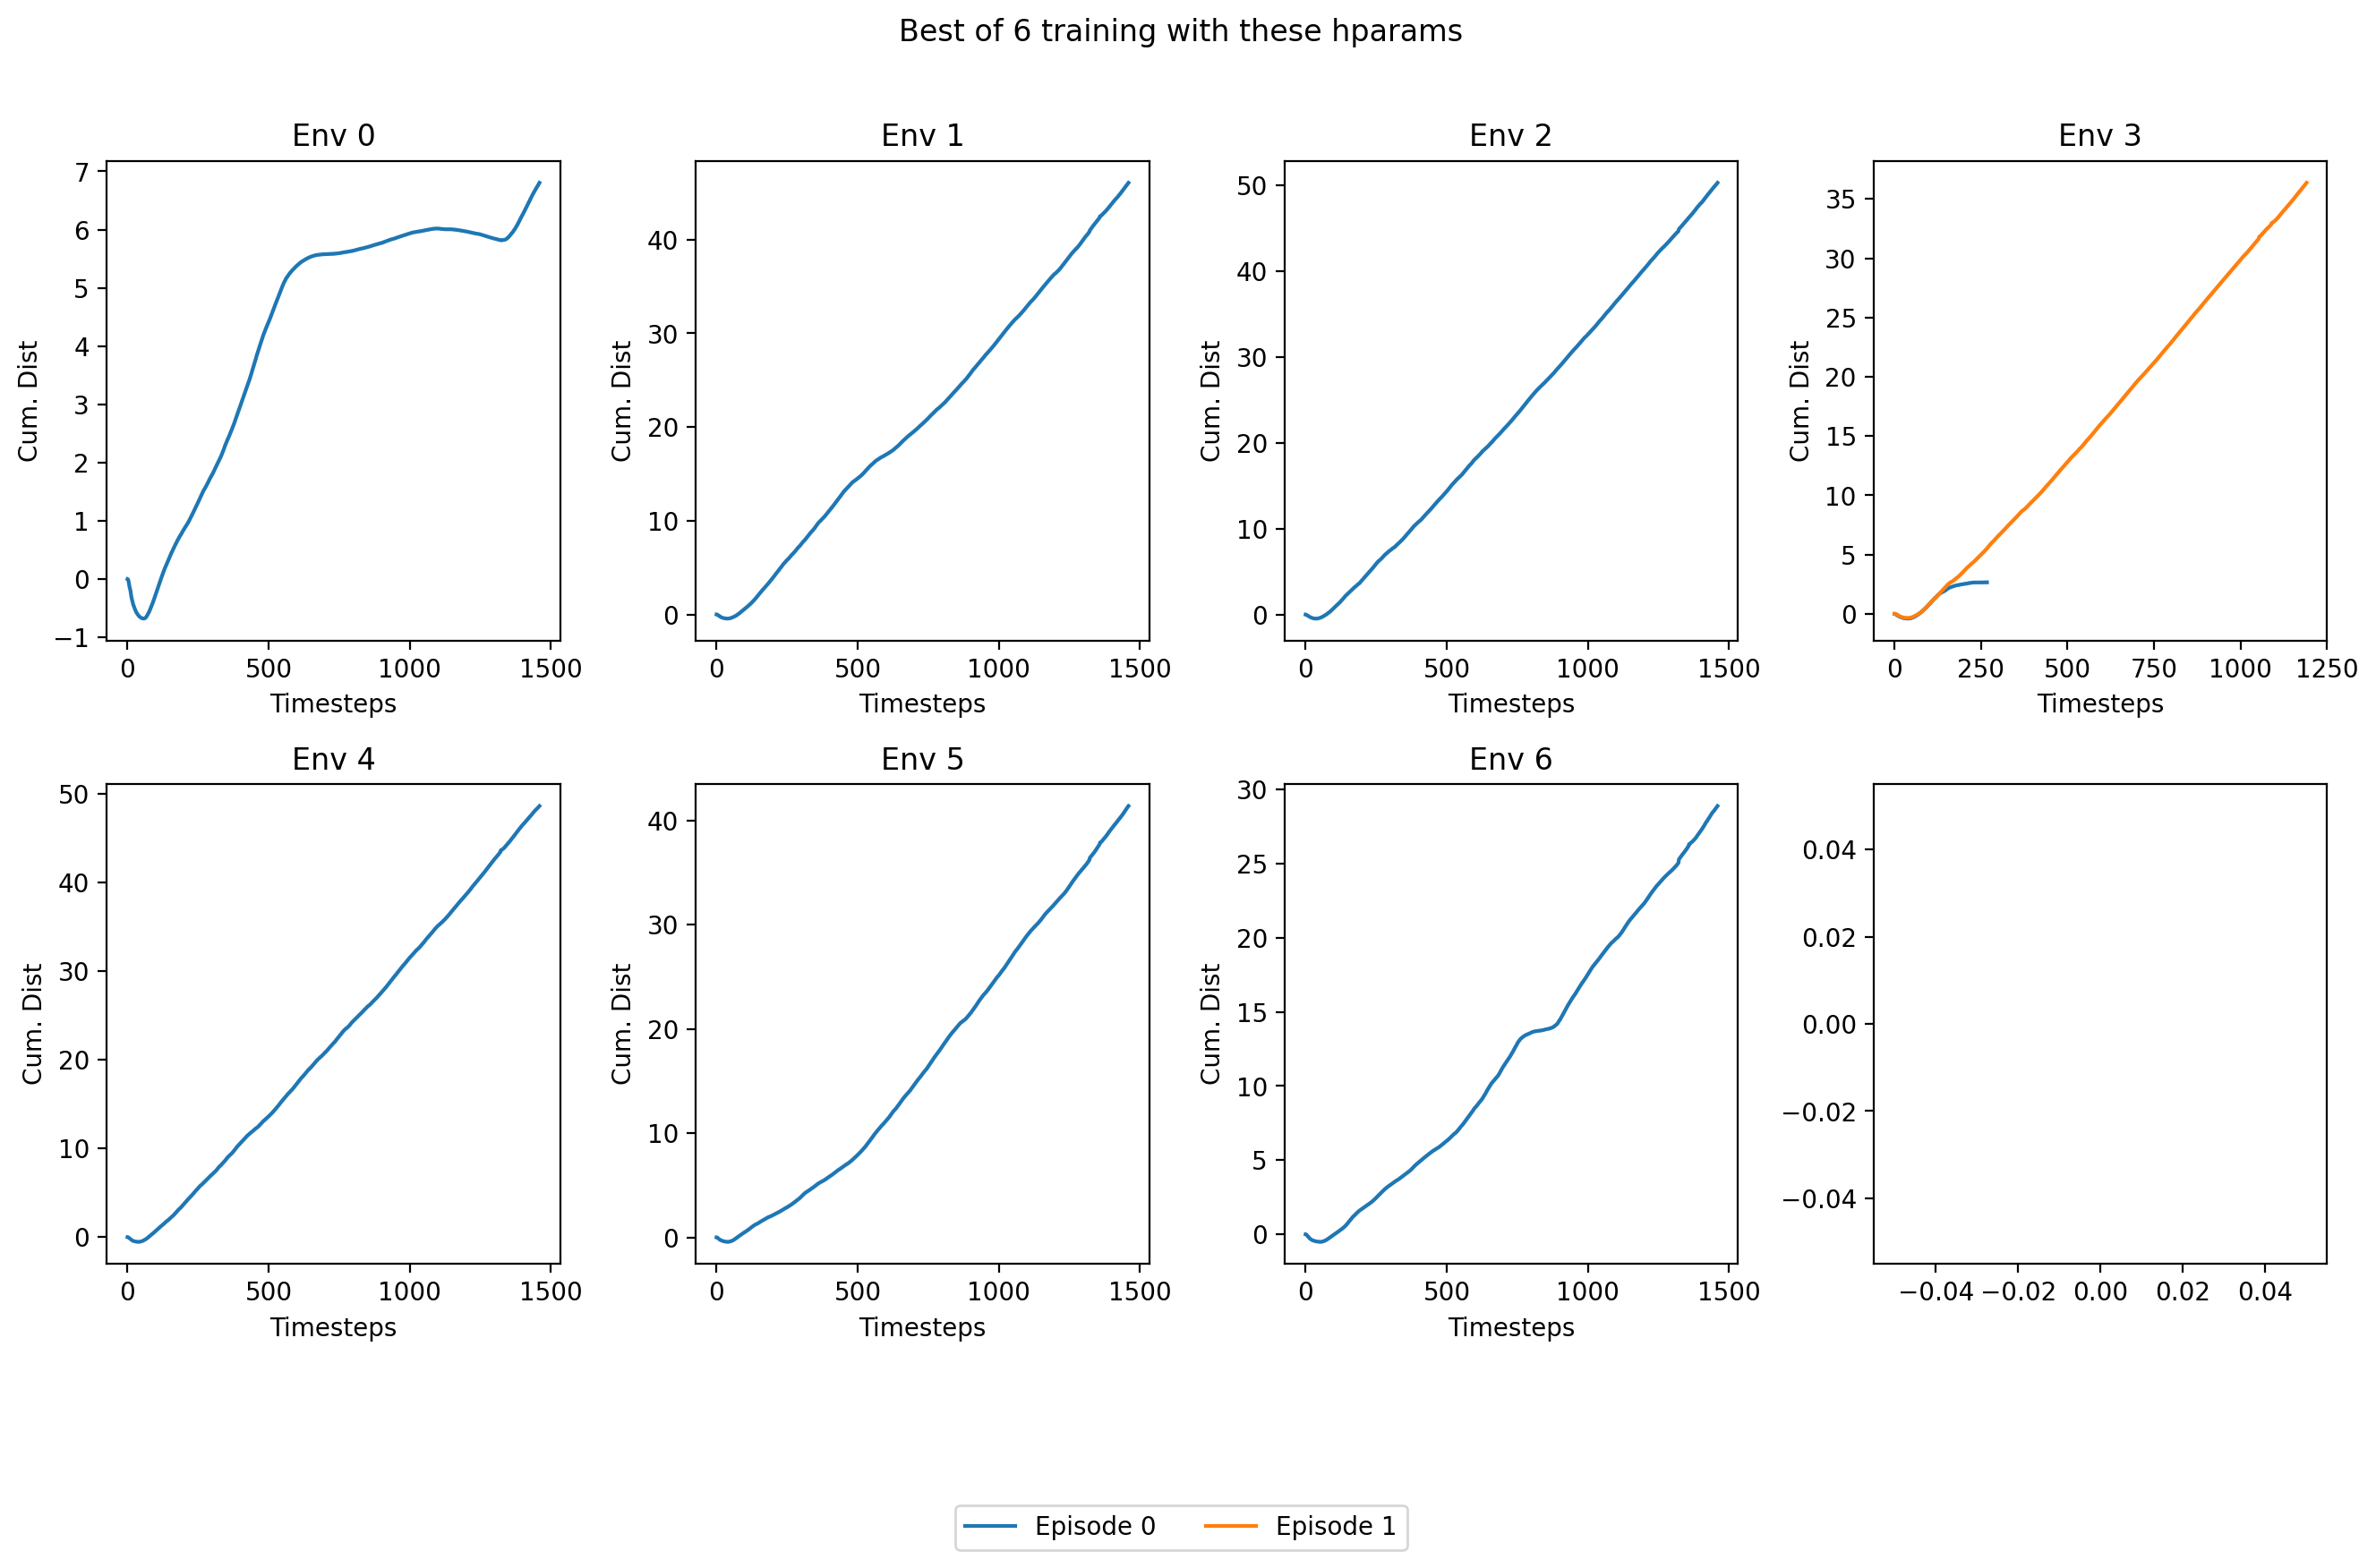

In [9]:
plot_gain_dist_by_episode('08-29-max-wind-v1-optuna-hparams-13-1', train=True, title='Best of 6 training with these hparams');

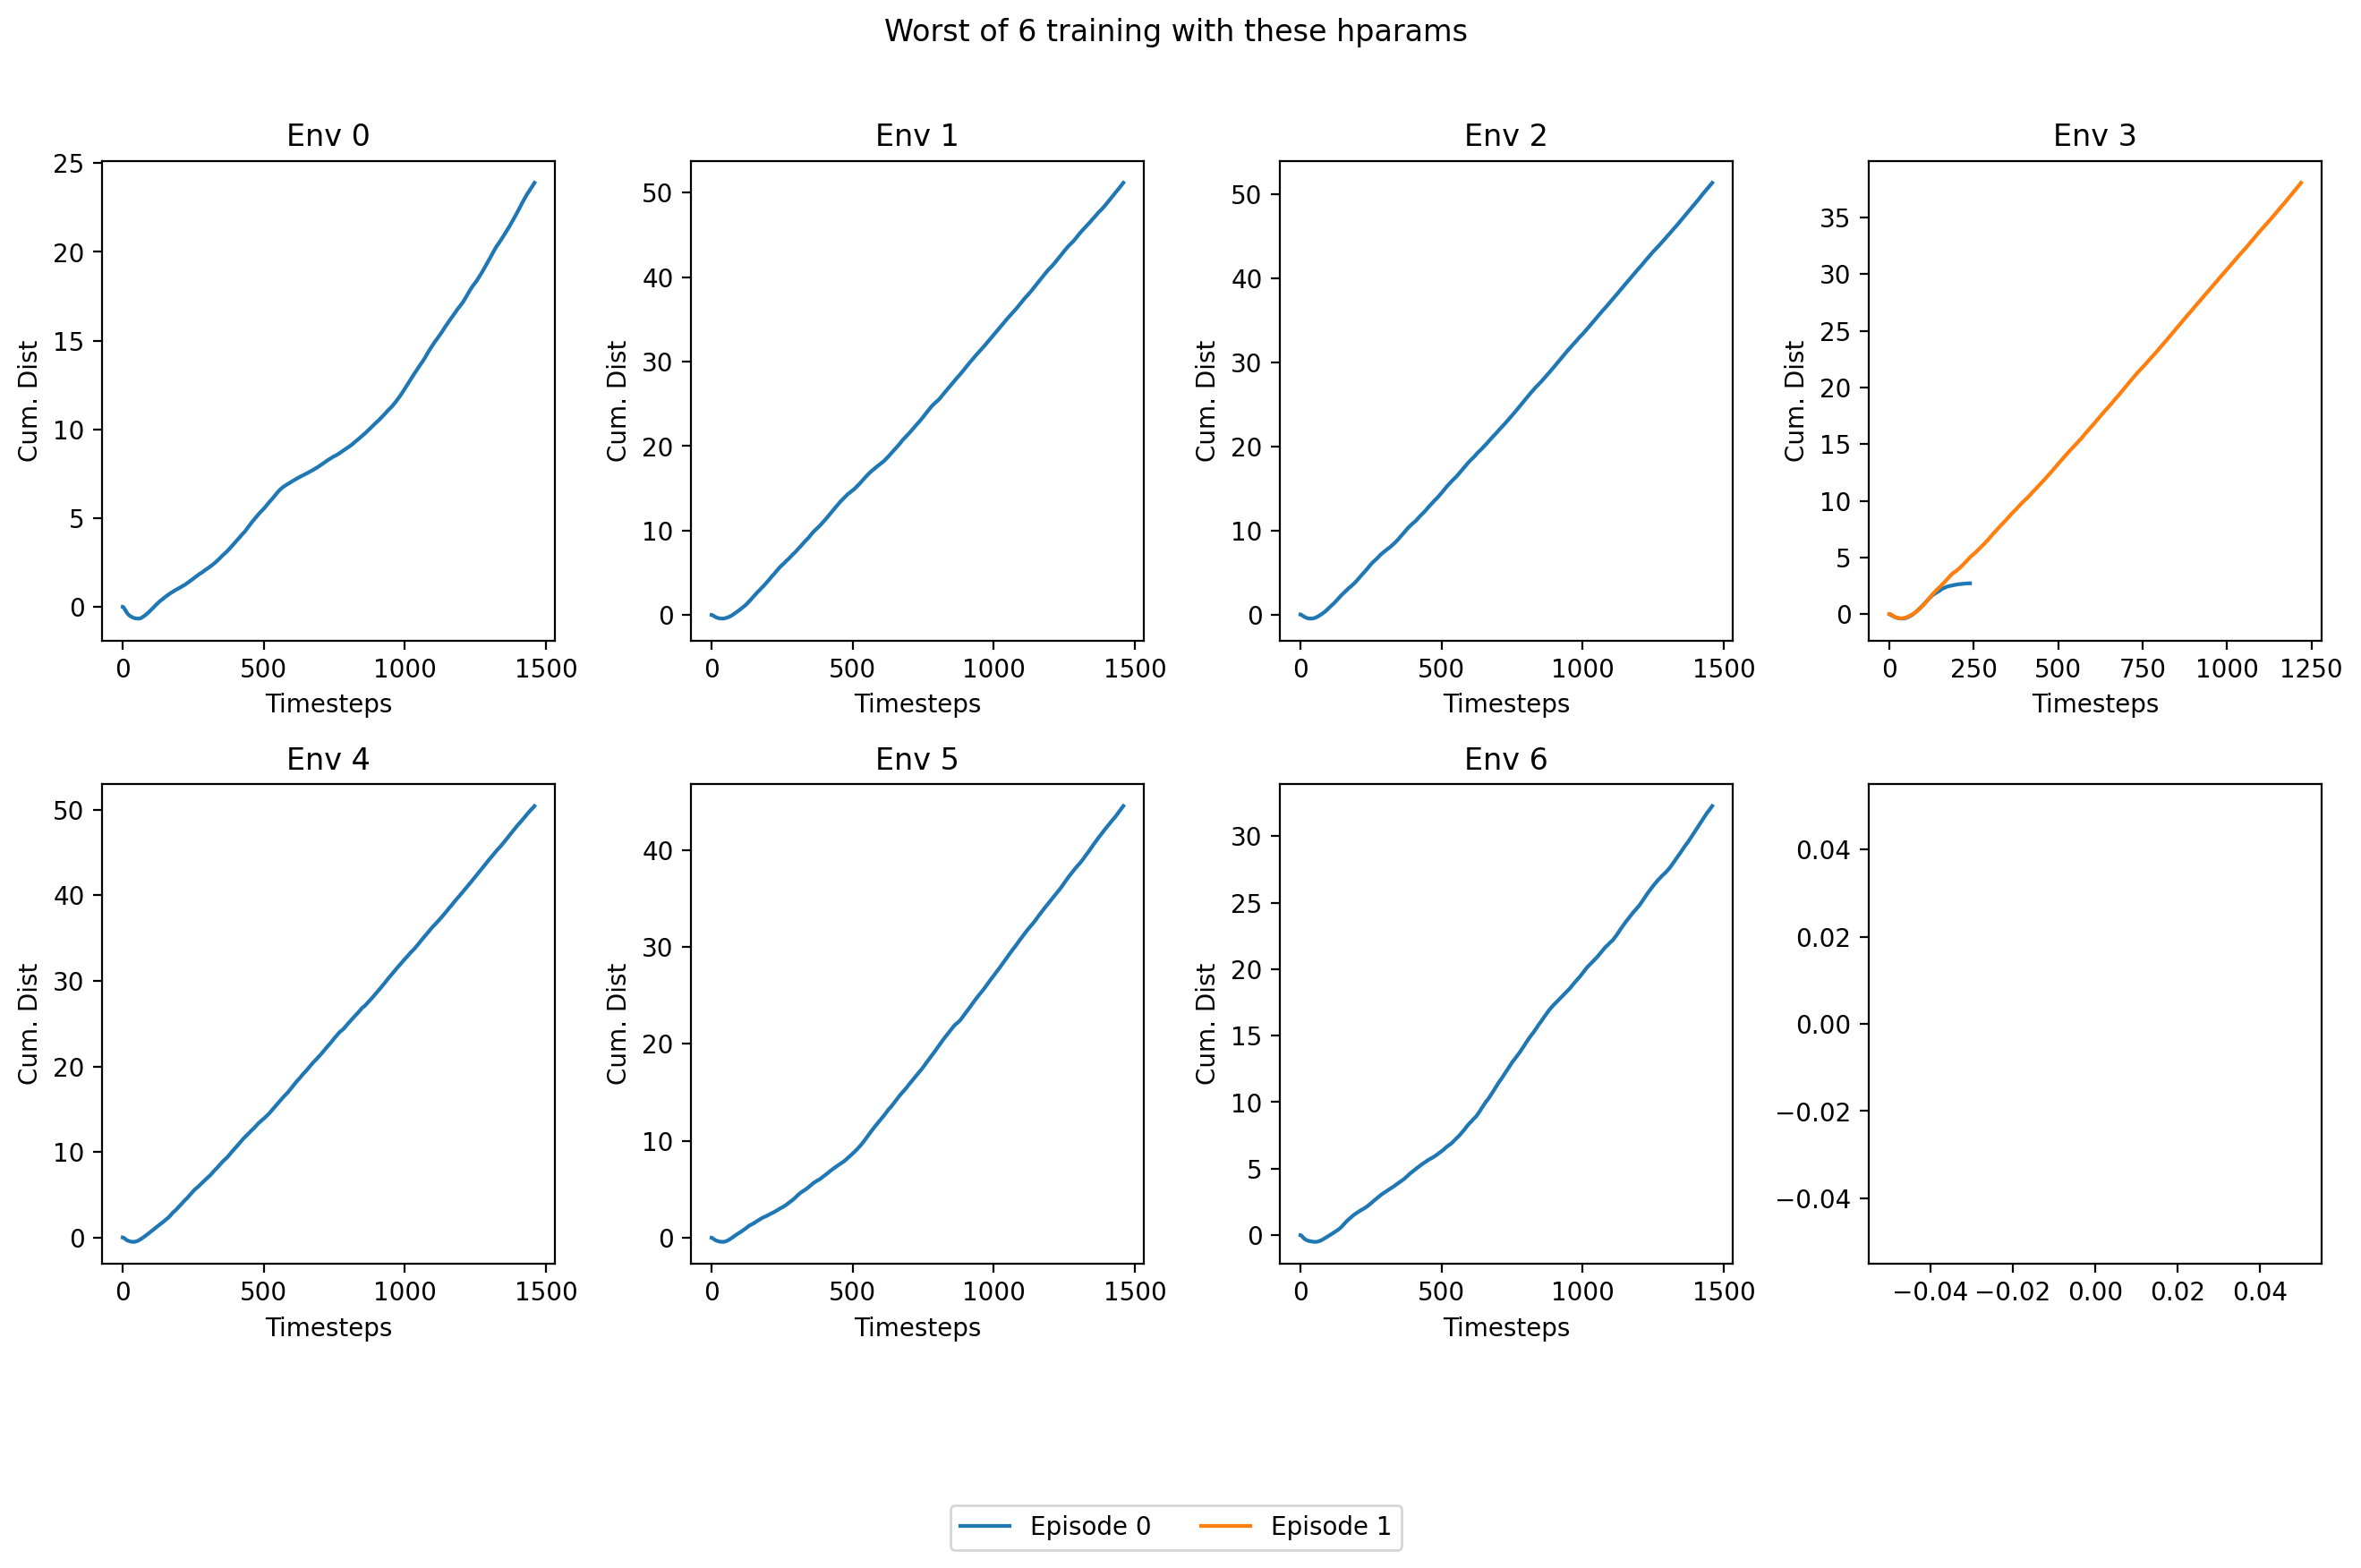

In [10]:
plot_gain_dist_by_episode('08-29-max-wind-v1-optuna-hparams-13-5', train=True, title='Worst of 6 training with these hparams');

# Best reward hyperparameters

In [57]:
get_k_best_hyperparams(5, study_name='09-01-reward-tuning-A')
print()
get_k_best_hyperparams(10, study_name='09-01-reward-tuning-A')
print()
get_k_best_hyperparams(20, study_name='09-01-reward-tuning-A')
print()
get_k_best_hyperparams(50, study_name='09-01-reward-tuning-A')

Best hyperparameters (k=5):
	rudder_coef:	7.08e-01±2.10e-01 (median=7.58e-01)
	start_penality:	6.01e-01±1.45e-01 (median=5.59e-01)
	vmc_steepness:	1.54e+01±3.54e+00 (median=1.52e+01)
	xte_steepness:	1.88e+01±1.04e+00 (median=1.90e+01)

Best hyperparameters (k=10):
	rudder_coef:	7.07e-01±2.41e-01 (median=7.50e-01)
	start_penality:	5.49e-01±1.20e-01 (median=5.21e-01)
	vmc_steepness:	1.40e+01±3.86e+00 (median=1.50e+01)
	xte_steepness:	1.63e+01±4.66e+00 (median=1.88e+01)

Best hyperparameters (k=20):
	rudder_coef:	6.42e-01±2.55e-01 (median=6.81e-01)
	start_penality:	5.62e-01±1.26e-01 (median=5.42e-01)
	vmc_steepness:	1.37e+01±4.82e+00 (median=1.42e+01)
	xte_steepness:	1.50e+01±4.77e+00 (median=1.60e+01)

Best hyperparameters (k=50):
	rudder_coef:	4.39e-01±3.20e-01 (median=4.09e-01)
	start_penality:	5.37e-01±2.24e-01 (median=5.28e-01)
	vmc_steepness:	1.14e+01±6.33e+00 (median=1.26e+01)
	xte_steepness:	1.18e+01±6.15e+00 (median=1.28e+01)


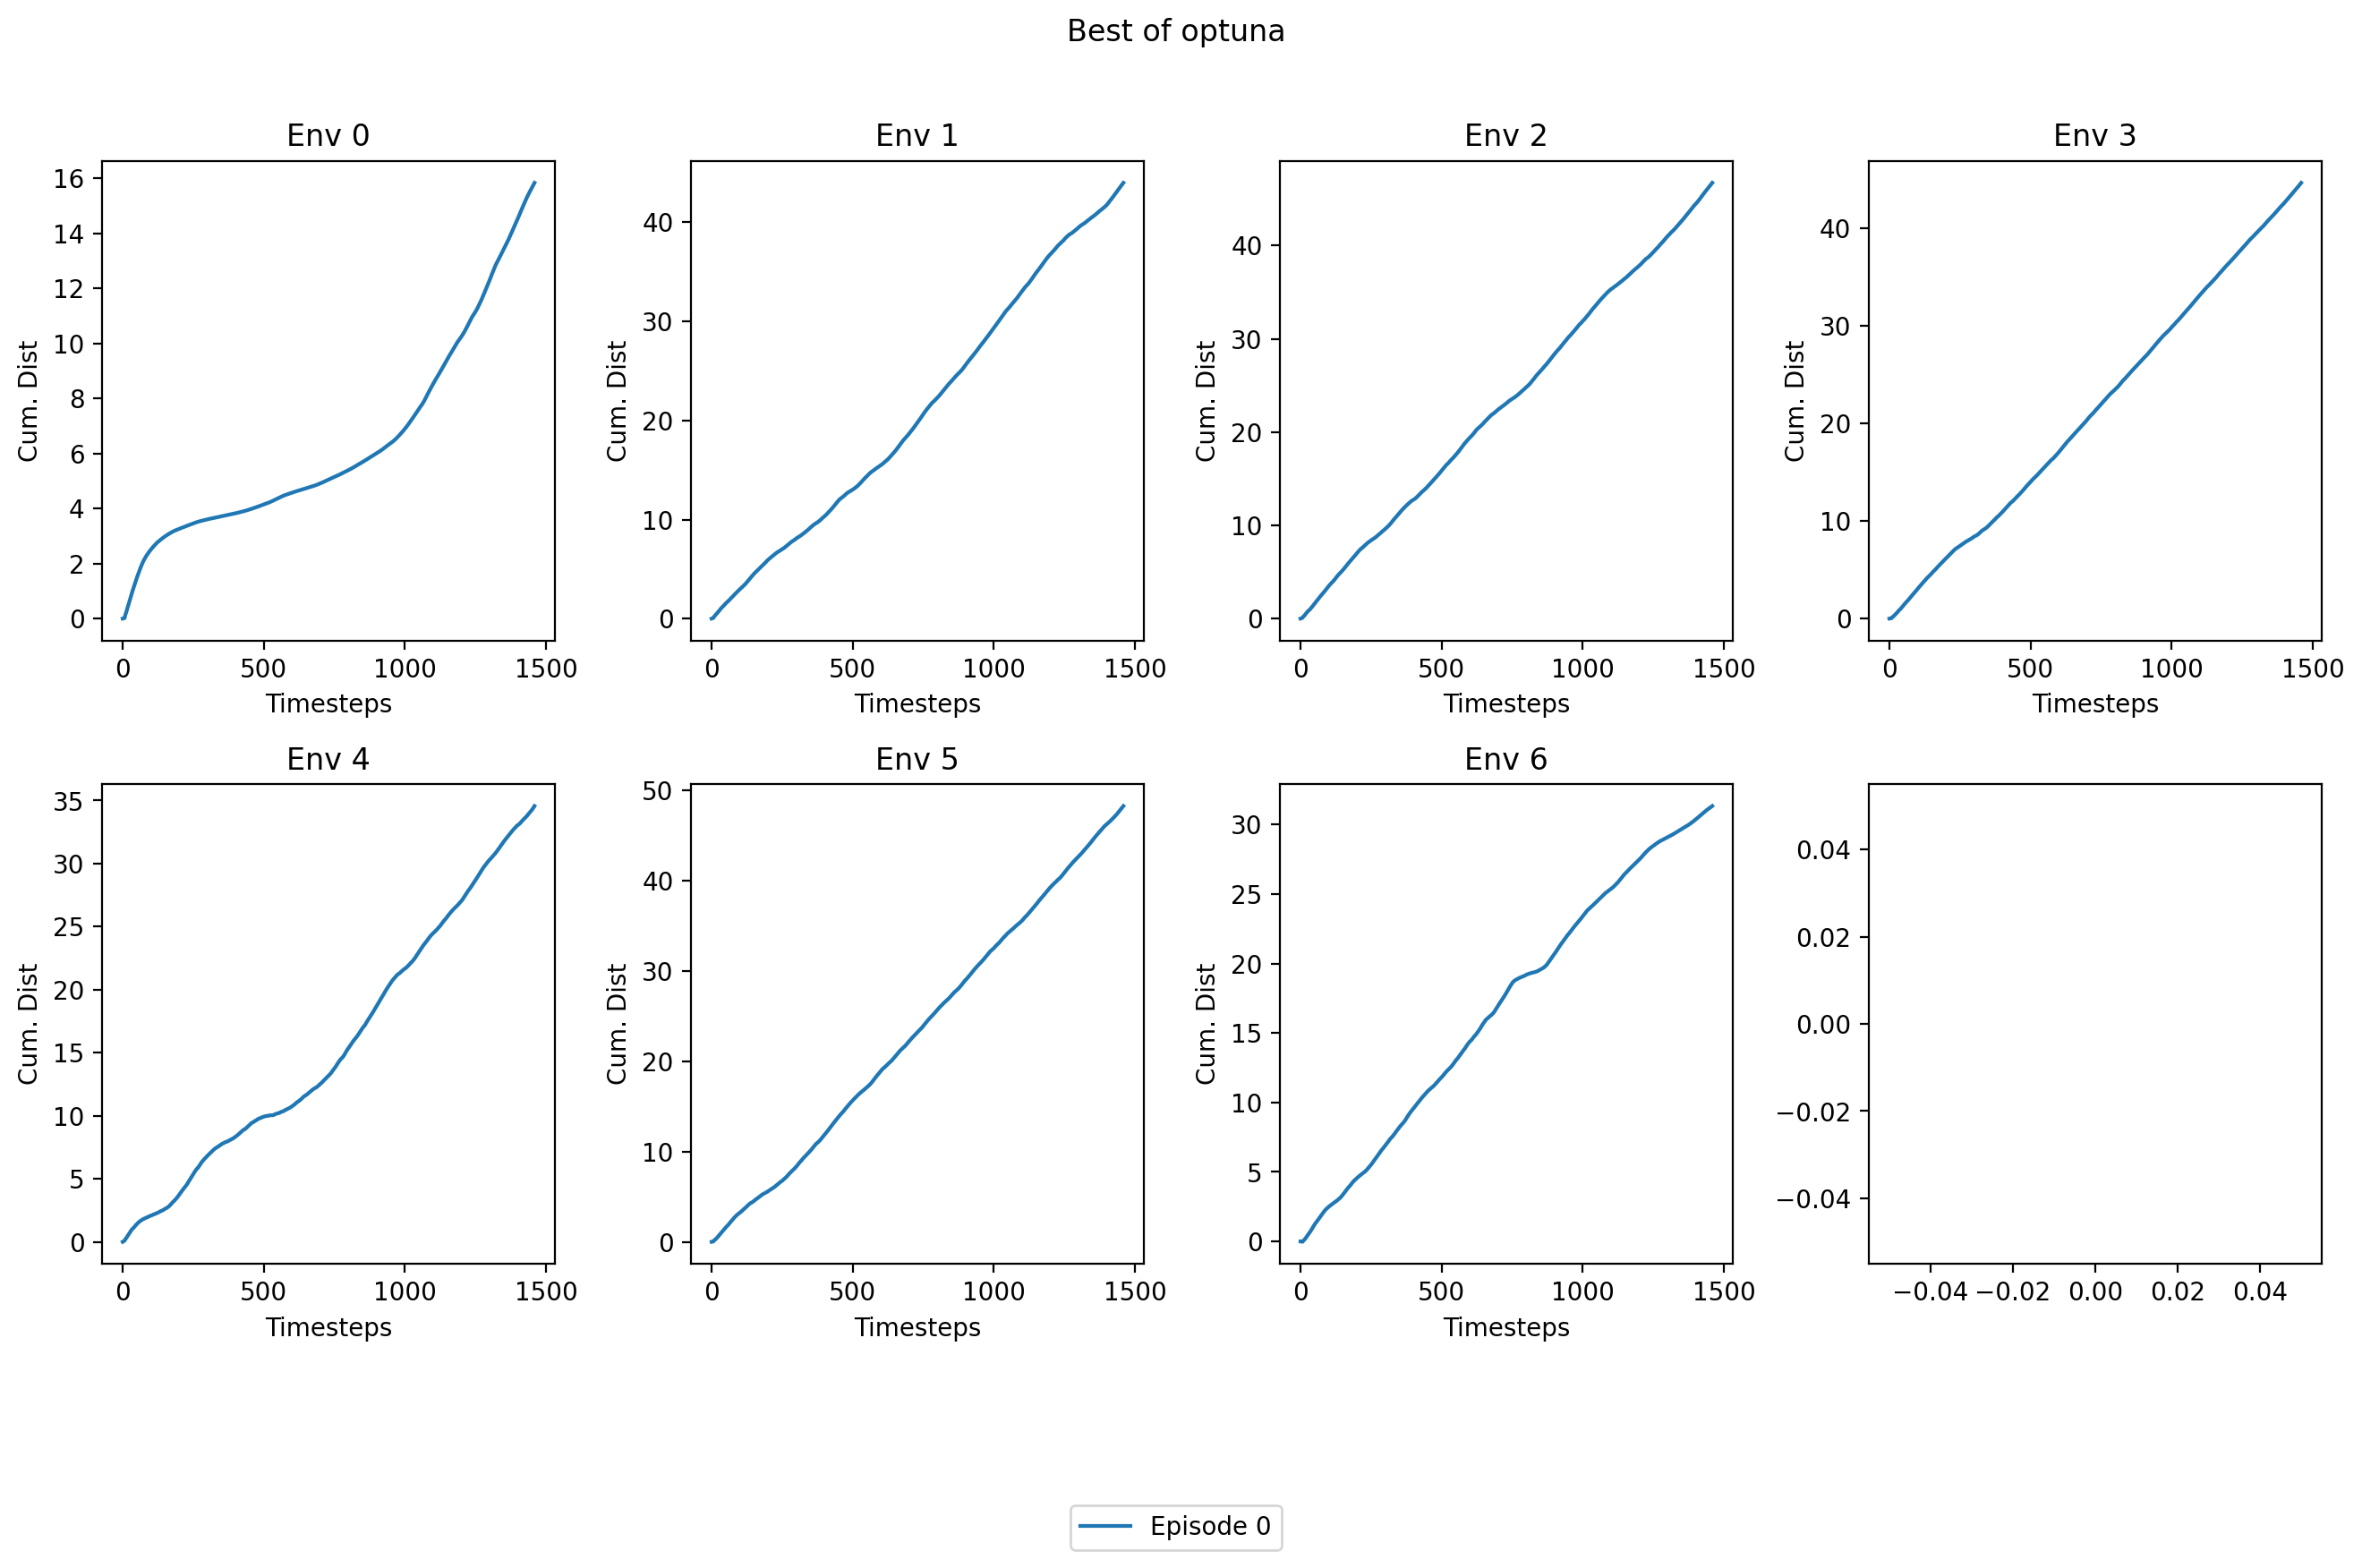

In [56]:
plot_gain_dist_by_episode('09-01-reward-tuning-A-13', train=True, title='Best of optuna');

In [15]:
import optuna

get_k_best_hyperparams(5, study_name='09-01-reward-tuning-scenario-2-20K-exp-reward')
print()
get_k_best_hyperparams(10, study_name='09-01-reward-tuning-scenario-2-20K-exp-reward')
print()
get_k_best_hyperparams(20, study_name='09-01-reward-tuning-scenario-2-20K-exp-reward')
print()
get_k_best_hyperparams(50, study_name='09-01-reward-tuning-scenario-2-20K-exp-reward')

Best hyperparameters (k=5):
	rudder_coef:	7.69e-03±9.14e-03 (median=3.79e-03)
	vmc_coef:	1.98e-01±2.96e-01 (median=6.92e-02)
	xte_coef:	1.35e-01±2.91e-01 (median=1.50e-03)

Best hyperparameters (k=10):
	rudder_coef:	1.81e-02±2.23e-02 (median=7.67e-03)
	vmc_coef:	1.34e-01±2.25e-01 (median=5.09e-02)
	xte_coef:	2.86e-01±3.58e-01 (median=2.71e-02)

Best hyperparameters (k=20):
	rudder_coef:	6.95e-02±1.54e-01 (median=6.91e-03)
	vmc_coef:	1.34e-01±2.21e-01 (median=4.95e-02)
	xte_coef:	1.84e-01±2.90e-01 (median=2.46e-02)

Best hyperparameters (k=50):
	rudder_coef:	6.95e-02±1.54e-01 (median=6.91e-03)
	vmc_coef:	1.34e-01±2.21e-01 (median=4.95e-02)
	xte_coef:	1.84e-01±2.90e-01 (median=2.46e-02)


In [18]:
import optuna

get_k_best_hyperparams(5, study_name='09-03-reward-tuning-scenario-1-10K-custom-reward')
print()
get_k_best_hyperparams(10, study_name='09-03-reward-tuning-scenario-1-10K-custom-reward')
print()
get_k_best_hyperparams(20, study_name='09-03-reward-tuning-scenario-1-10K-custom-reward')
print()
get_k_best_hyperparams(50, study_name='09-03-reward-tuning-scenario-1-10K-custom-reward')

Best hyperparameters (k=5):
	rudder_coef:	4.50e-02±4.79e-02 (median=1.89e-02)
	vmc_coef:	3.26e-01±2.41e-01 (median=2.80e-01)
	vmc_start_penality:	4.86e-01±2.49e-01 (median=5.97e-01)
	vmc_steepness:	1.70e+00±2.70e-01 (median=1.77e+00)
	xte_coef:	2.44e-02±4.05e-02 (median=8.09e-03)
	xte_start_penality:	3.56e-01±2.31e-01 (median=2.61e-01)
	xte_steepness:	5.37e+00±2.09e+00 (median=5.77e+00)

Best hyperparameters (k=10):
	rudder_coef:	5.37e-02±6.67e-02 (median=1.89e-02)
	vmc_coef:	4.76e-01±2.70e-01 (median=4.31e-01)
	vmc_start_penality:	5.04e-01±1.92e-01 (median=5.93e-01)
	vmc_steepness:	1.79e+00±4.03e-01 (median=1.81e+00)
	xte_coef:	1.17e-01±3.07e-01 (median=9.38e-03)
	xte_start_penality:	2.41e-01±2.07e-01 (median=2.42e-01)
	xte_steepness:	5.38e+00±2.32e+00 (median=5.61e+00)

Best hyperparameters (k=20):
	rudder_coef:	4.72e-02±4.92e-02 (median=3.16e-02)
	vmc_coef:	4.43e-01±2.20e-01 (median=4.04e-01)
	vmc_start_penality:	4.97e-01±2.22e-01 (median=5.68e-01)
	vmc_steepness:	1.70e+00±3.61e-01 

## What is the empirical bound of the rudder derivative? **$\approx 5$**

Failed to load 36 files for 08-29-max-wind-v1-optuna-hparams-13-*/**/**


<Axes: xlabel='Timesteps', ylabel='dt_theta_rudder'>

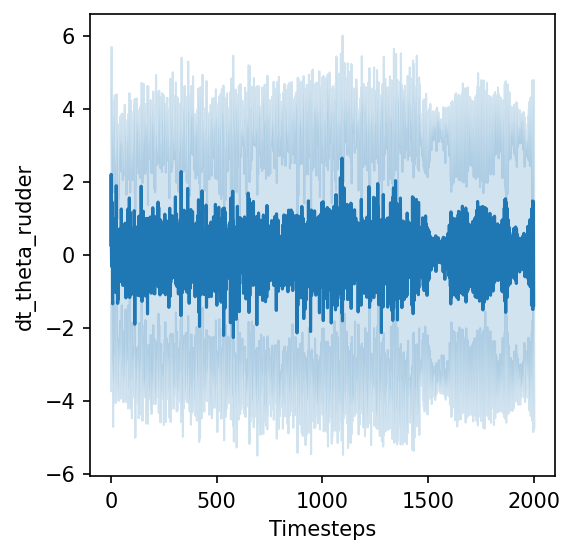

In [13]:
plot_metric(['08-29-max-wind-v1-optuna-hparams-13-*/**/**'], metric='obs/dt_theta_rudder/0', y_label='dt_theta_rudder', hide_legend=True)

## What is the emprical bound of the gain distance? **$\approx 0.05$**

Failed to load 36 files for 08-29-max-wind-v1-optuna-hparams-13-*/**/**


<Axes: xlabel='Timesteps', ylabel='gain_dist'>

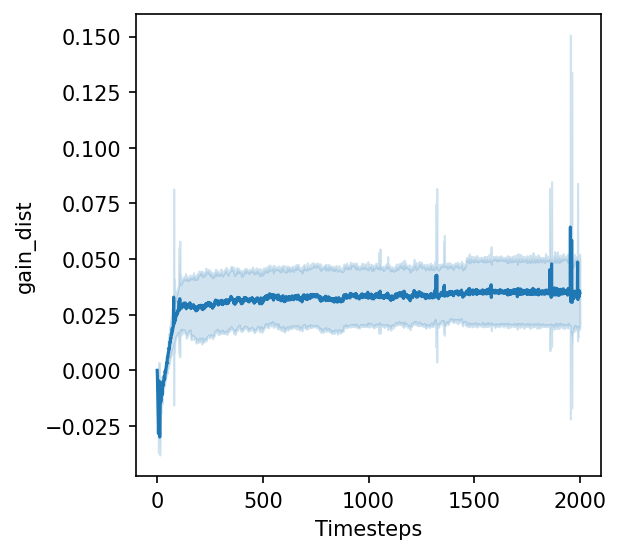

In [14]:
plot_metric(['08-29-max-wind-v1-optuna-hparams-13-*/**/**'], metric='obs/gain_dist/0', y_label='gain_dist', hide_legend=True)

# Scenario 0

## $T = 10.000$

In [ ]:
plot_gain_dist_by_episode('08-29-max-wind-v1-optuna-hparams-13-1', train=True, title='Best of 6 training with these hparams');

In [101]:
def plot_gain_dist_by_episode(name, title=None, train=False):
  folder = 'train' if train else 'eval'
  n_envs = len(glob(f'../runs/{name}/{folder}-*'))
  max_nb_episodes = max([len(glob(f'../runs/{name}/{folder}-{name}*{i}/*')) for i in range(n_envs)])

  n_rows = n_envs // 4 + 1
  n_cols = 4
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4), dpi=200)

  def extract_label(filename):
    res = re.search(r'(\d)/(\d)/progress.csv', filename)
    return f'Env {res.group(1)}, Episode {res.group(2)}'

  for env_id in range(n_envs):
    axs_x = env_id // 4
    axs_y = env_id % 4
    ax = axs[axs_x, axs_y]
    ax.set_title(f'Env {env_id}')
    plot_metric(
      [f'{name}/{folder}-{name}*{env_id}/{i}' for i in range(max_nb_episodes)],
      metric='obs/cum_obs/gain_dist/0',
      y_label=f'Cum. Dist',
      ax=ax,
      hide_legend=True)
  for i in range(max_nb_episodes):
    axs[1, 3].plot([], [], label=f'Episode {i}')

  plt.subplots_adjust(wspace=0.3, hspace=0.3)
  fig.suptitle(title or name)
  fig.legend(loc='upper center',
              bbox_to_anchor=(0.5, -.05),
              ncol=4)

In [ ]:

# for i, (name, label) in enumerate(zip(names, labels)):
#   if blacklist is not None:
#     files = [file for file in files if blacklist not in file]
#   data = []
#   for file in tqdm(files, desc=label, leave=False):
#     mean_xte = 0
#     mean_dist = 0
#     envs = glob(f'{file}/eval-*/0/*.csv')
#     if len(envs) == 0:
#       continue
#     for env in envs:
#       try:
#         df = pd.read_csv(env)
#         mean_xte += np.abs(df["obs/xte/0"]).mean()
#         mean_dist += df["obs/cum_obs/vmc/0"].iloc[-1]*.1
#       except:
#         continue
#     mean_xte /= len(envs)
#     mean_dist /= len(envs)
#     data.append([mean_dist, mean_xte])
#   data = np.array(data)
#   pickle.dump(data, open(f'../{name}_pareto.pkl', 'wb'))
#   plot_pareto_optimal_line(data, label=label, color=colors[i])

# plt.ylim(0, 10)
# plt.xlabel('Cumulative distance')
# plt.ylabel('XTE')
# plt.title('Pareto Optimal Line')
# plt.legend()
# plt.show()


Loading data:   0%|          | 0/104 [00:00<?, ?it/s]

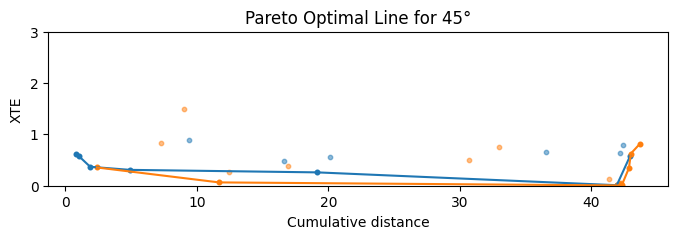

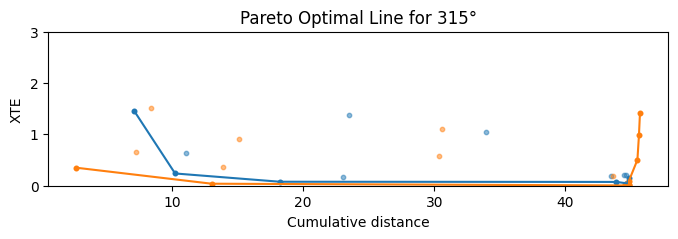

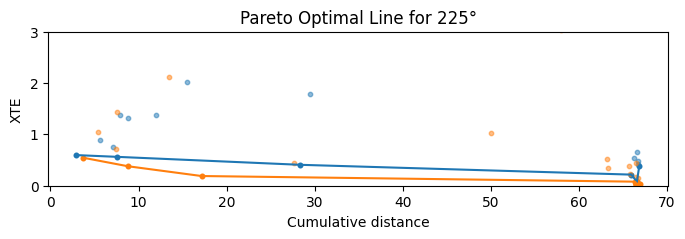

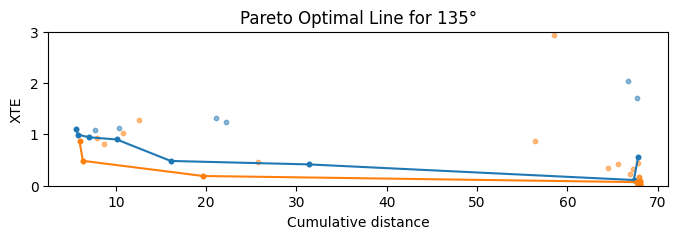

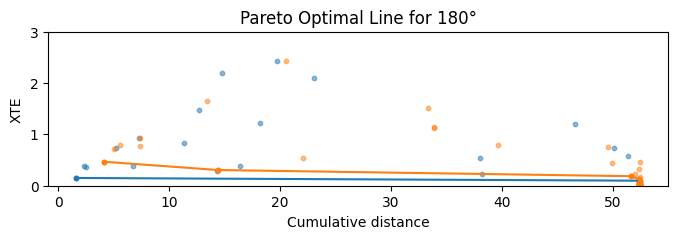

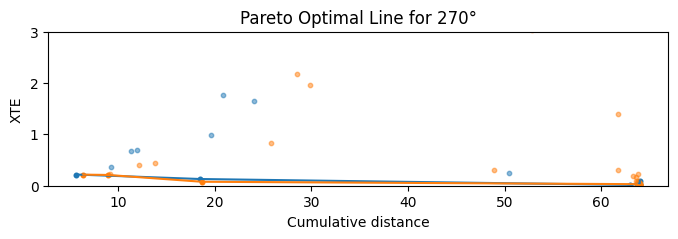

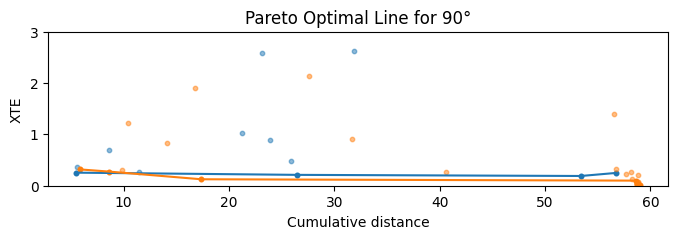

In [71]:
names = [
  '09-01-pid-los-scenario-1-*^indiv',
  '09-01-pid-los-scenario-1-indiv*',
]
labels = ['LOS', 'LOS-INDIV']

import pickle
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import pandas as pd

def plot_pareto_optimal_line(data, label=None, color=None):
  # Sort the data based on the first dimension (maximizing)
  sorted_data = data[np.argsort(data[:, 0])]
  pareto_front_left = [sorted_data[0]]
  for point in sorted_data[1:]:
    if point[1] <= pareto_front_left[-1][1]:
      pareto_front_left.append(point)

  sorted_data = data[np.argsort(data[:, 0])[::-1]]
  pareto_front_right = [sorted_data[0]]
  for point in sorted_data[1:]:
    if point[1] <= pareto_front_right[-1][1]:
      pareto_front_right.append(point)

  pareto_front = pareto_front_left[:-1] + pareto_front_right[::-1]
  pareto_front = np.array(pareto_front)
  plt.scatter(data[:, 0], data[:, 1], label=label, s=10, alpha=0.5, color=color)
  plt.scatter(pareto_front[:, 0], pareto_front[:, 1], s=10, color=color)
  plt.plot(pareto_front[:, 0], pareto_front[:, 1], color=color)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']


from collections import defaultdict
import re

score_by_angle_1 = defaultdict(list)
for file in tqdm(glob('../runs/09-01-pid-xte-scenario-1-indiv-*', recursive=True), desc='Loading data', leave=False):
  deg = int(re.search(r'(\d+)deg', file).group(1))
  files = glob(f'{file}/eval-*/0/*.csv')
  assert len(files) == 1
  df = pd.read_csv(files[0])
  xte = df['obs/xte/0'].abs().mean()
  dist = df['obs/cum_obs/vmc/0'].iloc[-1]*.1
  score_by_angle_1[deg].append([dist, xte])

score_by_angle_2 = defaultdict(list)
for file in tqdm(glob('../runs/09-01-pid-xte-scenario-1-*', recursive=True), desc='Loading data', leave=False):
  if 'indiv' in file:
    continue
  files = glob(f'{file}/eval-*')
  for file in files:
    deg = int(re.search(r'(\d+)deg', file).group(1))
    files = glob(f'{file}/0/*.csv')
    df = pd.read_csv(files[0])
    xte = df['obs/xte/0'].abs().mean()
    dist = df['obs/cum_obs/vmc/0'].iloc[-1]*.1
    score_by_angle_2[deg].append([dist, xte])

score_by_angle_3 = defaultdict(list)
for file in tqdm(glob('../runs/09-01-pid-los-scenario-1-indiv-*', recursive=True), desc='Loading data', leave=False):
  deg = int(re.search(r'(\d+)deg', file).group(1))
  files = glob(f'{file}/eval-*/0/*.csv')
  assert len(files) == 1
  df = pd.read_csv(files[0])
  xte = df['obs/xte/0'].abs().mean()
  dist = df['obs/cum_obs/vmc/0'].iloc[-1]*.1
  score_by_angle_3[deg].append([dist, xte])

score_by_angle_4 = defaultdict(list)
for file in tqdm(glob('../runs/09-01-pid-los-scenario-1-*', recursive=True), desc='Loading data', leave=False):
  if 'indiv' in file:
    continue
  files = glob(f'{file}/eval-*')
  for file in files:
    deg = int(re.search(r'(\d+)deg', file).group(1))
    files = glob(f'{file}/0/*.csv')
    df = pd.read_csv(files[0])
    xte = df['obs/xte/0'].abs().mean()
    dist = df['obs/cum_obs/vmc/0'].iloc[-1]*.1
    score_by_angle_4[deg].append([dist, xte])

for angle in score_by_angle_1:
  plt.figure(figsize=(8, 2))
  scores_1 = np.array(score_by_angle_1[angle])
  plot_pareto_optimal_line(scores_1, label='PID XTE indiv.', color='C0')
  scores_2 = np.array(score_by_angle_2[angle])
  plot_pareto_optimal_line(scores_2, label='PID XTE', color='C1')
  # scores_3 = np.array(score_by_angle_3[angle])
  # plot_pareto_optimal_line(scores_3, label='PID LOS indiv.', color='C2')
  # scores_4 = np.array(score_by_angle_4[angle])
  # plot_pareto_optimal_line(scores_4, label='PID LOS', color='C3')
  plt.ylim(0, 3)
  plt.xlabel('Cumulative distance')
  plt.ylabel('XTE')
  plt.title(f'Pareto Optimal Line for {angle}°')
  # plt.legend()
  plt.savefig(f'../09-01-pid-xte-scenario-1-{angle}deg.svg')


Loading data:   6%|▋         | 6/96 [00:00<00:01, 52.88it/s]

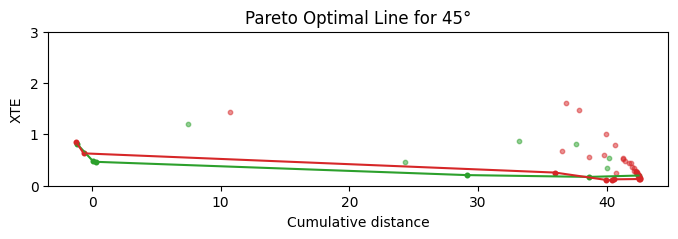

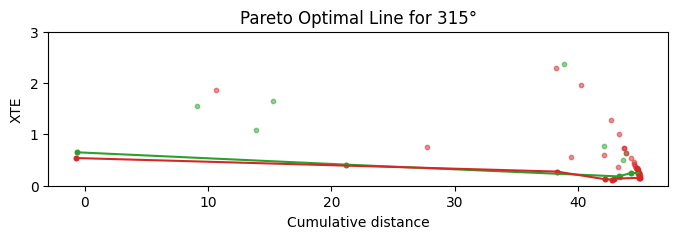

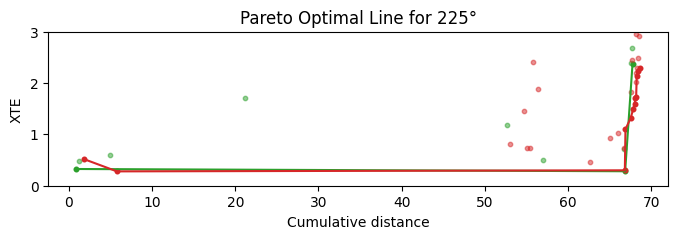

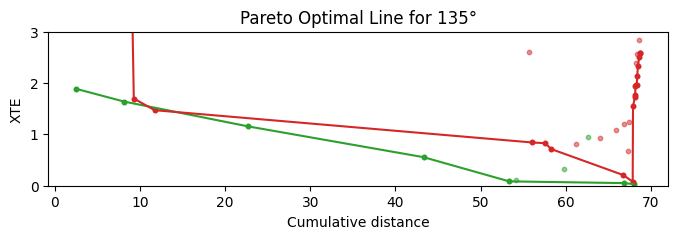

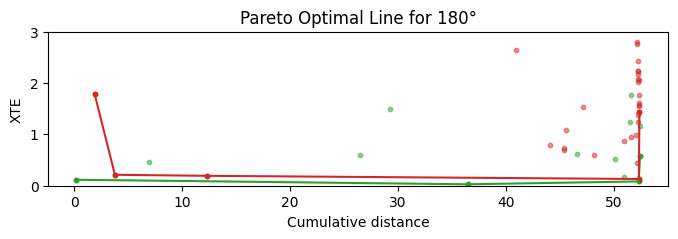

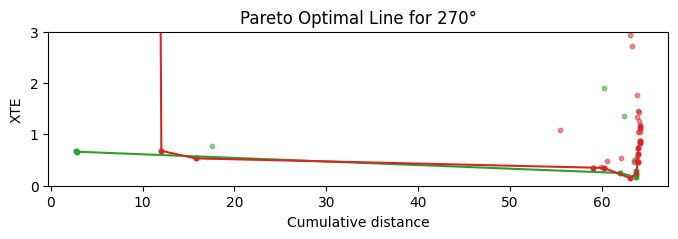

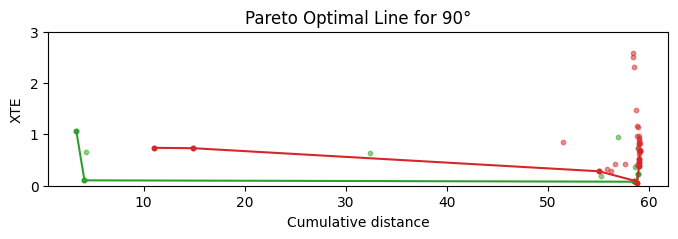

In [69]:
names = [
  '09-01-pid-los-scenario-1-*^indiv',
  '09-01-pid-los-scenario-1-indiv*',
]
labels = ['LOS', 'LOS-INDIV']

import pickle
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import pandas as pd

def plot_pareto_optimal_line(data, label=None, color=None):
  # Sort the data based on the first dimension (maximizing)
  sorted_data = data[np.argsort(data[:, 0])]
  pareto_front_left = [sorted_data[0]]
  for point in sorted_data[1:]:
    if point[1] <= pareto_front_left[-1][1]:
      pareto_front_left.append(point)

  sorted_data = data[np.argsort(data[:, 0])[::-1]]
  pareto_front_right = [sorted_data[0]]
  for point in sorted_data[1:]:
    if point[1] <= pareto_front_right[-1][1]:
      pareto_front_right.append(point)

  pareto_front = pareto_front_left[:-1] + pareto_front_right[::-1]
  pareto_front = np.array(pareto_front)
  plt.scatter(data[:, 0], data[:, 1], label=label, s=10, alpha=0.5, color=color)
  plt.scatter(pareto_front[:, 0], pareto_front[:, 1], s=10, color=color)
  plt.plot(pareto_front[:, 0], pareto_front[:, 1], color=color)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']


from collections import defaultdict
import re

score_by_angle_3 = defaultdict(list)
for file in tqdm(glob('../runs/09-01-pid-los-scenario-1-indiv-*', recursive=True), desc='Loading data', leave=False):
  deg = int(re.search(r'(\d+)deg', file).group(1))
  files = glob(f'{file}/eval-*/0/*.csv')
  assert len(files) == 1
  df = pd.read_csv(files[0])
  xte = df['obs/xte/0'].abs().mean()
  dist = df['obs/cum_obs/vmc/0'].iloc[-1]*.1
  score_by_angle_3[deg].append([dist, xte])

score_by_angle_4 = defaultdict(list)
for file in tqdm(glob('../runs/09-01-pid-los-scenario-1-*', recursive=True), desc='Loading data', leave=False):
  if 'indiv' in file:
    continue
  files = glob(f'{file}/eval-*')
  for file in files:
    deg = int(re.search(r'(\d+)deg', file).group(1))
    files = glob(f'{file}/0/*.csv')
    df = pd.read_csv(files[0])
    xte = df['obs/xte/0'].abs().mean()
    dist = df['obs/cum_obs/vmc/0'].iloc[-1]*.1
    score_by_angle_4[deg].append([dist, xte])

for angle in score_by_angle_1:
  plt.figure(figsize=(8, 2))
  # scores_1 = np.array(score_by_angle_1[angle])
  # plot_pareto_optimal_line(scores_1, label='PID XTE indiv.', color='C0')
  # scores_2 = np.array(score_by_angle_2[angle])
  # plot_pareto_optimal_line(scores_2, label='PID XTE', color='C1')
  scores_3 = np.array(score_by_angle_3[angle])
  plot_pareto_optimal_line(scores_3, label='PID LOS indiv.', color='C2')
  scores_4 = np.array(score_by_angle_4[angle])
  plot_pareto_optimal_line(scores_4, label='PID LOS', color='C3')
  plt.ylim(0, 3)
  plt.xlabel('Cumulative distance')
  plt.ylabel('XTE')
  plt.title(f'Pareto Optimal Line for {angle}°')
  # plt.legend()
  plt.savefig(f'../09-01-pid-los-scenario-1-{angle}deg.svg')


Loading data:   0%|          | 0/144 [00:00<?, ?it/s]

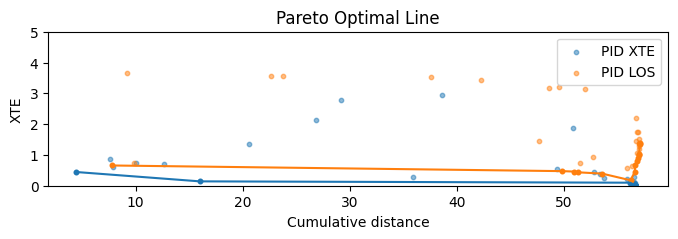

In [72]:
names = [
  '09-01-pid-los-scenario-1-*^indiv',
  '09-01-pid-los-scenario-1-indiv*',
]
labels = ['LOS', 'LOS-INDIV']

import pickle
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import pandas as pd

def plot_pareto_optimal_line(data, label=None, color=None):
  # Sort the data based on the first dimension (maximizing)
  sorted_data = data[np.argsort(data[:, 0])]
  pareto_front_left = [sorted_data[0]]
  for point in sorted_data[1:]:
    if point[1] <= pareto_front_left[-1][1]:
      pareto_front_left.append(point)

  sorted_data = data[np.argsort(data[:, 0])[::-1]]
  pareto_front_right = [sorted_data[0]]
  for point in sorted_data[1:]:
    if point[1] <= pareto_front_right[-1][1]:
      pareto_front_right.append(point)

  pareto_front = pareto_front_left[:-1] + pareto_front_right[::-1]
  pareto_front = np.array(pareto_front)
  plt.scatter(data[:, 0], data[:, 1], label=label, s=10, alpha=0.5, color=color)
  plt.scatter(pareto_front[:, 0], pareto_front[:, 1], s=10, color=color)
  plt.plot(pareto_front[:, 0], pareto_front[:, 1], color=color)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']


from collections import defaultdict
import re


# for file in tqdm(glob('../runs/09-01-pid-xte-scenario-1-indiv-*', recursive=True), desc='Loading data', leave=False):
#   deg = int(re.search(r'(\d+)deg', file).group(1))
#   files = glob(f'{file}/eval-*/0/*.csv')
#   assert len(files) == 1
#   df = pd.read_csv(files[0])
#   xte = df['obs/xte/0'].abs().mean()
#   dist = df['obs/cum_obs/vmc/0'].iloc[-1]*.1
#   score_by_angle[deg].append([dist, xte])
score_by_type = defaultdict(list)

for file in tqdm(glob('../runs/09-01-pid-xte-scenario-1-*', recursive=True), desc='Loading data', leave=False):
  if 'indiv' in file:
    continue
  files = glob(f'{file}/eval-*')
  mean_xte = 0
  mean_dist = 0
  for file in files:
    deg = int(re.search(r'(\d+)deg', file).group(1))
    file = glob(f'{file}/0/*.csv')[0]
    df = pd.read_csv(file)
    xte = df['obs/xte/0'].abs().mean()
    dist = df['obs/cum_obs/vmc/0'].iloc[-1]*.1
    mean_xte += xte
    mean_dist += dist
  mean_xte /= len(files)
  mean_dist /= len(files)
  score_by_type['PID XTE'].append([mean_dist, mean_xte])


# for file in tqdm(glob('../runs/09-01-pid-los-scenario-1-indiv-*', recursive=True), desc='Loading data', leave=False):
#   deg = int(re.search(r'(\d+)deg', file).group(1))
#   files = glob(f'{file}/eval-*/0/*.csv')
#   assert len(files) == 1
#   df = pd.read_csv(files[0])
#   xte = df['obs/xte/0'].abs().mean()
#   dist = df['obs/cum_obs/vmc/0'].iloc[-1]*.1
#   score_by_angle[deg].append([dist, xte])

for file in tqdm(glob('../runs/09-01-pid-los-scenario-1-*', recursive=True), desc='Loading data', leave=False):
  if 'indiv' in file:
    continue
  files = glob(f'{file}/eval-*')
  mean_xte = 0
  mean_dist = 0
  for file in files:
    file = glob(f'{file}/0/*.csv')[0]
    df = pd.read_csv(file)
    xte = df['obs/xte/0'].abs().mean()
    dist = df['obs/cum_obs/vmc/0'].iloc[-1]*.1
    mean_xte += xte
    mean_dist += dist
  mean_xte /= len(files)
  mean_dist /= len(files)
  score_by_type['PID LOS'].append([mean_dist, mean_xte])



# for file in tqdm(glob('../runs/09-01-pid-los-scenario-1-*', recursive=True), desc='Loading data', leave=False):
#   if 'indiv' in file:
#     continue
#   files = glob(f'{file}/eval-*')
#   mean_xte = 0
#   mean_dist = 0
#   for file in files:
#     deg = int(re.search(r'(\d+)deg', file).group(1))
#     files = glob(f'{file}/0/*.csv')
#     df = pd.read_csv(files[0])
#     xte = df['obs/xte/0'].abs().mean()
#     dist = df['obs/cum_obs/vmc/0'].iloc[-1]*.1
#     mean_xte += xte
#     mean_dist += dist
#   mean_xte /= len(files)
#   mean_dist /= len(files)
#   score_by_type['PID LOS'].append([mean_dist, mean_xte])


plt.figure(figsize=(8, 2))
for i, algo in enumerate(score_by_type):
  scores = np.array(score_by_type[algo])
  plot_pareto_optimal_line(scores, label=algo, color=f'C{i}')
plt.ylim(0, 5)
plt.xlabel('Cumulative distance')
# plt.hlines(10, 0, 60, color='red', linestyle='--', label='Corridor')
plt.ylabel('XTE')
plt.title('Pareto Optimal Line')
# plt.legend()
plt.savefig(f'../09-01-pids-scenario-1.svg')


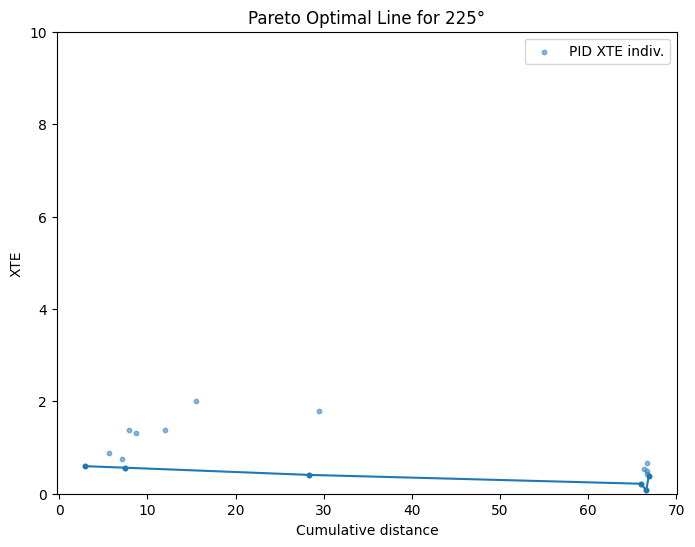

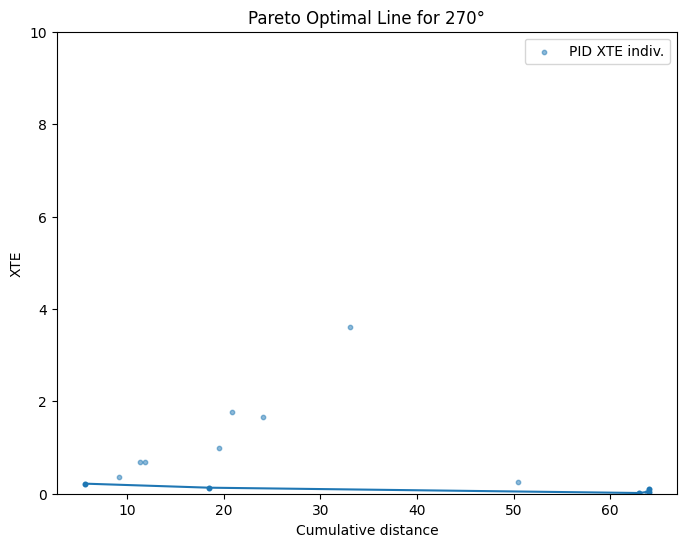

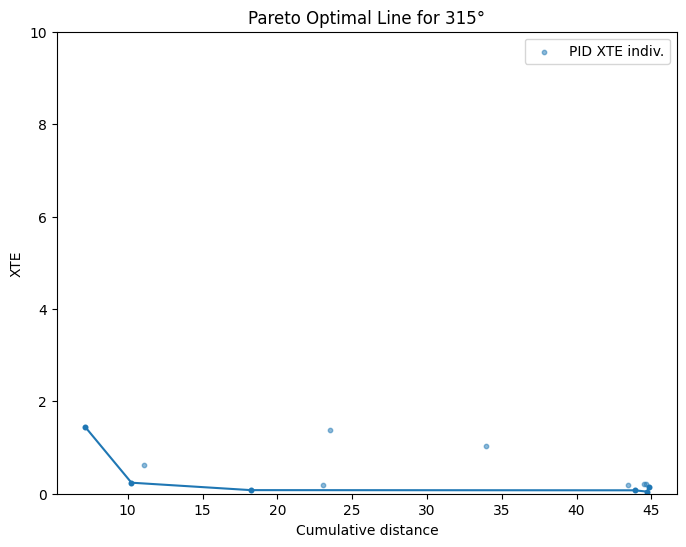

In [34]:
names = [
  '09-01-pid-los-scenario-1-*^indiv',
  '09-01-pid-los-scenario-1-indiv*',
]
labels = ['LOS', 'LOS-INDIV']

import pickle
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import pandas as pd

def plot_pareto_optimal_line(data, label=None, color=None):
  # Sort the data based on the first dimension (maximizing)
  sorted_data = data[np.argsort(data[:, 0])]
  pareto_front_left = [sorted_data[0]]
  for point in sorted_data[1:]:
    if point[1] <= pareto_front_left[-1][1]:
      pareto_front_left.append(point)

  sorted_data = data[np.argsort(data[:, 0])[::-1]]
  pareto_front_right = [sorted_data[0]]
  for point in sorted_data[1:]:
    if point[1] <= pareto_front_right[-1][1]:
      pareto_front_right.append(point)

  pareto_front = pareto_front_left[:-1] + pareto_front_right[::-1]
  pareto_front = np.array(pareto_front)
  plt.scatter(data[:, 0], data[:, 1], label=label, s=10, alpha=0.5, color=color)
  plt.scatter(pareto_front[:, 0], pareto_front[:, 1], s=10, color=color)
  plt.plot(pareto_front[:, 0], pareto_front[:, 1], color=color)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']


from collections import defaultdict
import re


# for file in tqdm(glob('../runs/09-01-pid-xte-scenario-1-indiv-*', recursive=True), desc='Loading data', leave=False):
#   deg = int(re.search(r'(\d+)deg', file).group(1))
#   files = glob(f'{file}/eval-*/0/*.csv')
#   assert len(files) == 1
#   df = pd.read_csv(files[0])
#   xte = df['obs/xte/0'].abs().mean()
#   dist = df['obs/cum_obs/vmc/0'].iloc[-1]*.1
#   score_by_angle[deg].append([dist, xte])
score_by_type = defaultdict(list)

for file in tqdm(glob('../runs/09-01-pid-xte-scenario-1-*', recursive=True), desc='Loading data', leave=False):
  if 'indiv' in file:
    continue
  files = glob(f'{file}/eval-*')
  mean_xte = 0
  mean_dist = 0
  for file in files:
    deg = int(re.search(r'(\d+)deg', file).group(1))
    file = glob(f'{file}/0/*.csv')[0]
    df = pd.read_csv(file)
    xte = df['obs/xte/0'].abs().mean()
    dist = df['obs/cum_obs/vmc/0'].iloc[-1]*.1
    mean_xte += xte
    mean_dist += dist
  mean_xte /= len(files)
  mean_dist /= len(files)
  score_by_type['PID XTE'].append([mean_dist, mean_xte])


# for file in tqdm(glob('../runs/09-01-pid-los-scenario-1-indiv-*', recursive=True), desc='Loading data', leave=False):
#   deg = int(re.search(r'(\d+)deg', file).group(1))
#   files = glob(f'{file}/eval-*/0/*.csv')
#   assert len(files) == 1
#   df = pd.read_csv(files[0])
#   xte = df['obs/xte/0'].abs().mean()
#   dist = df['obs/cum_obs/vmc/0'].iloc[-1]*.1
#   score_by_angle[deg].append([dist, xte])

for file in tqdm(glob('../runs/09-01-pid-los-scenario-1-*', recursive=True), desc='Loading data', leave=False):
  if 'indiv' in file:
    continue
  files = glob(f'{file}/eval-*')
  mean_xte = 0
  mean_dist = 0
  for file in files:
    file = glob(f'{file}/0/*.csv')[0]
    df = pd.read_csv(file)
    xte = df['obs/xte/0'].abs().mean()
    dist = df['obs/cum_obs/vmc/0'].iloc[-1]*.1
    mean_xte += xte
    mean_dist += dist
  mean_xte /= len(files)
  mean_dist /= len(files)
  score_by_type['PID LOS'].append([mean_dist, mean_xte])



# for file in tqdm(glob('../runs/09-01-pid-los-scenario-1-*', recursive=True), desc='Loading data', leave=False):
#   if 'indiv' in file:
#     continue
#   files = glob(f'{file}/eval-*')
#   mean_xte = 0
#   mean_dist = 0
#   for file in files:
#     deg = int(re.search(r'(\d+)deg', file).group(1))
#     files = glob(f'{file}/0/*.csv')
#     df = pd.read_csv(files[0])
#     xte = df['obs/xte/0'].abs().mean()
#     dist = df['obs/cum_obs/vmc/0'].iloc[-1]*.1
#     mean_xte += xte
#     mean_dist += dist
#   mean_xte /= len(files)
#   mean_dist /= len(files)
#   score_by_type['PID LOS'].append([mean_dist, mean_xte])


plt.figure(figsize=(8, 2))
for i, algo in enumerate(score_by_type):
  scores = np.array(score_by_type[algo])
  plot_pareto_optimal_line(scores, label=algo, color=f'C{i}')
plt.ylim(0, 5)
plt.xlabel('Cumulative distance')
# plt.hlines(10, 0, 60, color='red', linestyle='--', label='Corridor')
plt.ylabel('XTE')
plt.title('Pareto Optimal Line')
# plt.legend()
plt.savefig(f'../09-01-pids-scenario-1.svg')
